## Lab Six: CNNs
GROUP MEMBERS:
- **Alex Chen** 
- **Paige Maple** 
- **Sam Valentine**

### Sources
1. ChatGPT (For formatting text and plots)

### Preparation (3 pts total)

We choose the Pistachio dataset from Lab 2 to perform a binary image classification task distinguishing between the *Kirmizi* and *Siirt* pistachio varieties. The dataset consists of uniformly sized pistachio images captured under controlled conditions, making it suitable for evaluating convolutional neural network architectures. The full dataset is available on Kaggle at: https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset.

#### Part One (1.5 pts)

**Evaluation Metric**

For this binary pistachio classification task, we use the **F1-score** as the primary evaluation metric. While accuracy is often used in image classification, it can be misleading—especially when the dataset is not perfectly balanced or when different misclassification types may have different practical consequences. In this setting, confusing *Kirmizi* with *Siirt* (or vice versa) could lead to incorrect sorting or labeling, resulting in economic loss.

The **F1-score**, defined as the harmonic mean of precision and recall, provides a balanced and informative single-value summary of model performance. Because it accounts for both how precise the model’s positive predictions are and how effectively it recalls all instances of a class, the F1-score offers a more reliable measure of classification quality than accuracy alone for this task.

In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# load the dataset
dataset_path = "../dataset/Pistachio_Image_Dataset"
img_size = (128, 128)

images = []
labels = []

for variety in os.listdir(dataset_path):
    variety_path = os.path.join(dataset_path, variety)
    if not os.path.isdir(variety_path):
        continue
    
    for filename in os.listdir(variety_path):
        file_path = os.path.join(variety_path, filename)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        img_resized = cv2.resize(img, img_size)
        img_norm = img_resized.astype("float32") / 255.0
        
        images.append(img_norm)
        labels.append(variety)

# convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# reshape for CNN: (N, 128, 128, 1)
X = images[..., np.newaxis]

# encode labels to 0/1
le = LabelEncoder()
y = le.fit_transform(labels)

print(X.shape)
print(y.shape)

(2148, 128, 128, 1)
(2148,)


#### Part Two (1.5 pts)

**Train/Test Splitting Method**

We evaluate our convolutional neural networks using an 80/20 shuffled train–test split. The pistachio dataset is well-balanced across the two classes and consists of independent image samples, making a simple randomized split both effective and appropriate. The 80% training portion provides sufficient data for the CNNs to learn meaningful visual features, while the remaining 20% is kept strictly for final model evaluation to obtain an unbiased estimate of real-world performance.

During training, we further reserve 20% of the training set as a validation set by using Keras’s `validation_split` parameter. This results in an effective data allocation of 64% for training, 16% for validation, and 20% for testing. This structure allows us to monitor model performance across epochs, detect overfitting, and compare different architectures using validation F1-scores, all while preserving a completely unseen test set for final assessment.

We use this simple shuffled split rather than k-fold cross-validation because deep CNNs are computationally expensive to train, and repeatedly retraining several architectures would significantly increase training time with diminishing returns. In practical computer-vision workflows, it is standard to train a model once using a fixed train/validation split and evaluate it on a held-out test set, which closely reflects how models are deployed in real applications.

A fixed random seed is used throughout the splitting process to ensure that all experiments are fully reproducible.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    shuffle=True,
    random_state=42,
    stratify=y
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1718, 128, 128, 1) (1718,)
(430, 128, 128, 1) (430,)


### Modeling (6 pts total)

#### Part One (1.5 pts)

**Data Augmentation Approach**

To improve the generalization ability of our convolutional neural networks, we apply data augmentation using Keras’s built-in augmentation layers. Although the pistachio images in this dataset are captured under controlled conditions, they still exhibit natural variations in orientation, position, and slight shape differences. In a real sorting or quality-control environment, pistachios may appear at different angles or slightly shifted within the camera frame. Data augmentation allows us to simulate these realistic variations and helps the model become more robust to them.

We use gentle transformations such as small rotations, slight translations, and horizontal/vertical flips. These operations preserve the essential visual characteristics of each pistachio while increasing the effective size and diversity of the training set. Since the objects are non-text and non-directional, these augmentations do not distort class-defining features. By adding this controlled randomness during training, the model is encouraged to learn more stable and generalizable feature representations rather than memorizing the training images.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# data augmentaion layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

#### Part Two (2 pts)

**Convolutional Network Architectures**

To evaluate the effectiveness of different convolutional designs on the pistachio classification task, we construct and compare two distinct CNN architectures. For each architecture, we also vary at least one key hyperparameter—such as the number of convolutional filters—to satisfy the requirement of training a minimum of four models. This allows us to examine how architectural depth and filter complexity affect feature extraction and classification performance.

Both architectures include the data augmentation pipeline defined earlier as the initial layer, ensuring that all models benefit from the same augmented training distribution. This keeps the comparison fair and isolates architectural differences as the main source of performance variation. Each model is followed by ReLU activations, max pooling, flattening, and a final dense classifier for binary output.

By training and evaluating all models using the same train/test split and the F1-score metric, we can directly compare their learning behavior and generalization ability. Training histories are recorded to visualize convergence patterns and determine whether additional depth or filter count improves feature learning without causing overfitting.

The two architectures are structured as follows:

**Architecture 1 (Shallow CNN):**  
Conv → MaxPool → Conv → MaxPool → Flatten → Dense → Output

**Architecture 2 (Deeper CNN):**  
Conv → Conv → MaxPool → Conv → Conv → MaxPool → Flatten → Dense → Output

In [10]:
import tensorflow as tf

# Architecture 1 (Shallow CNN)
def create_cnn_model_1(filters=32):
    model = keras.Sequential([
        data_augmentation,
        layers.Conv2D(filters, (3,3), activation="relu", input_shape=(128,128,1)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters*2, (3,3), activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

# Architecture 2 (Deeper CNN)
def create_cnn_model_2(filters=32):
    model = keras.Sequential([
        data_augmentation,
        layers.Conv2D(filters, (3,3), activation="relu", input_shape=(128,128,1)),
        layers.Conv2D(filters, (3,3), activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(filters*2, (3,3), activation="relu"),
        layers.Conv2D(filters*2, (3,3), activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

# Create 4 models
model1 = create_cnn_model_1(filters=32)
model1_large = create_cnn_model_1(filters=64)
model2 = create_cnn_model_2(filters=32)
model2_large = create_cnn_model_2(filters=64)

# Train models (NO CALLBACK)
history1 = model1.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)
history1_large = model1_large.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)
history2 = model2.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)
history2_large = model2_large.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.7154 - loss: 0.5399 - precision: 0.6800 - recall: 0.6155 - val_accuracy: 0.8023 - val_loss: 0.4442 - val_precision: 0.7348 - val_recall: 0.8693
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.7955 - loss: 0.4426 - precision: 0.7530 - recall: 0.7672 - val_accuracy: 0.8081 - val_loss: 0.4424 - val_precision: 0.7843 - val_recall: 0.7843
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8151 - loss: 0.4099 - precision: 0.7840 - recall: 0.7759 - val_accuracy: 0.8110 - val_loss: 0.4404 - val_precision: 0.8099 - val_recall: 0.7516
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.8137 - loss: 0.4113 - precision: 0.7872 - recall: 0.7655 - val_accuracy: 0.7994 - val_loss: 0.4857 - val_precision: 0.8387 - val_recall: 0.6797
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.8122 - loss: 0.4035 - precision: 0.7885 - recall: 0.7586 - val_accuracy: 0.8198 - val_loss: 0.

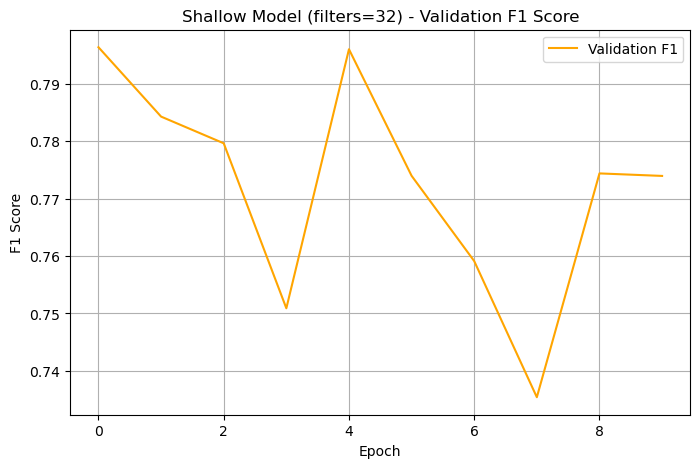

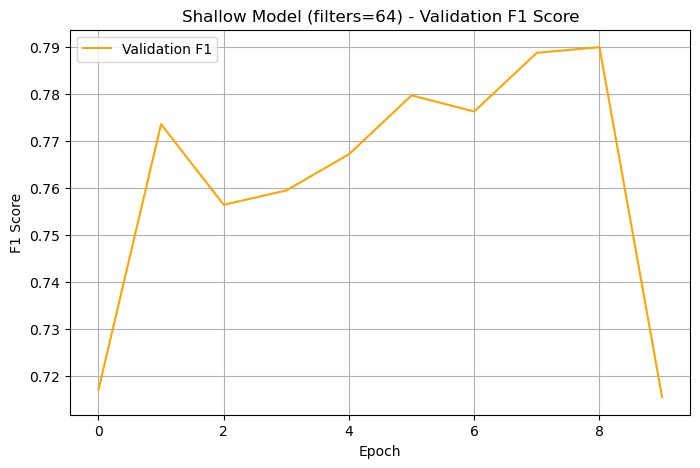

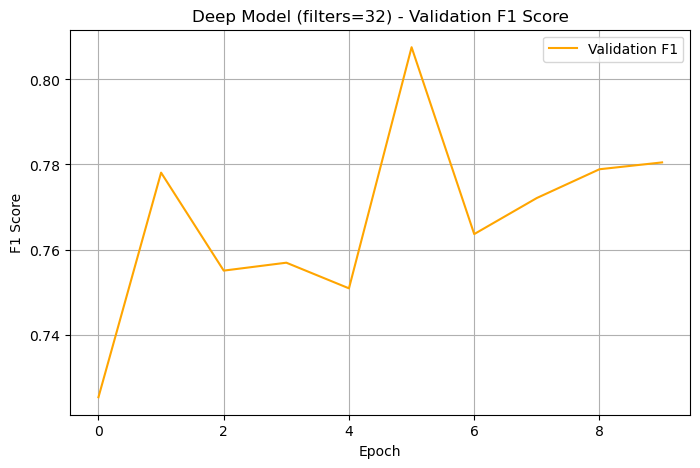

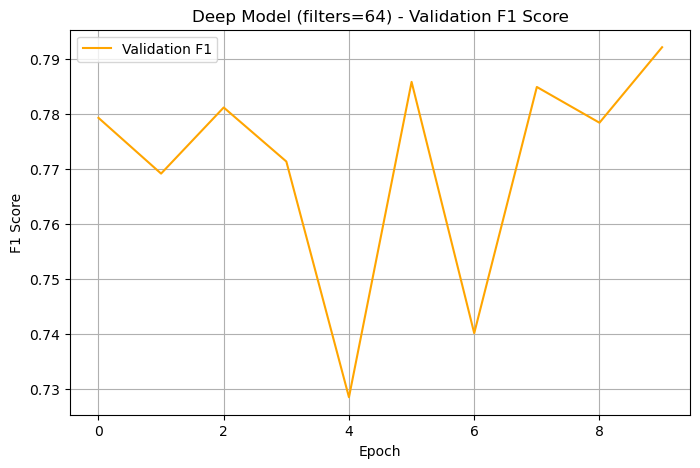

In [11]:
import matplotlib.pyplot as plt

# Helper function to plot training vs validation f1 score 
def plot_single_history_f1(history, title):
    precision = history.history['val_precision']
    recall = history.history['val_recall']
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
    plt.figure(figsize=(8,5))
    plt.plot(f1_scores, label='Validation F1', color='orange')
    plt.title(f'{title} - Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# visualize performance for train/validation set per iteration via f1 score (choosing evaluation metric)
plot_single_history_f1(history1, "Shallow Model (filters=32)")
plot_single_history_f1(history1_large, "Shallow Model (filters=64)")
plot_single_history_f1(history2, "Deep Model (filters=32)")
plot_single_history_f1(history2_large, "Deep Model (filters=64)")

#### Part Three (1.5 pts)

#### Part Four (1 pts)

### Exceptional Work (1 pts total)
One idea (required for 7000 level students): Use transfer learning with pre-trained weights for your initial layers of your CNN. Compare the performance when using transfer learning to your best model from above in terms of classification performance. 